In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [23]:
site_key = 'Telephone'
freq_key = 'HF'

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params

{'site_key': 'Telephone', 'HF_bci': 1374.7302159974931}

In [5]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_metrics_fixed = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)
bout_metrics_fixed

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-07-23 04:28:54.890500,2022-07-23 04:29:04.165100,1734.8905,1744.1651,1734.8905,1744.1651,41796.0,64800.0,HF,2022-07-23 04:00:00,2022-07-23 04:00:00,53,0 days 00:00:09.274600,9.2746
1,2022-07-23 04:30:11.839500,2022-07-23 04:30:14.868800,11.8395,14.8688,11.8395,14.8688,35781.0,70180.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,21,0 days 00:00:03.029300,3.0293
2,2022-07-23 04:32:11.407500,2022-07-23 04:32:18.033600,131.4075,138.0336,131.4075,138.0336,39218.0,63030.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,38,0 days 00:00:06.626100,6.6261
3,2022-07-23 04:32:25.987500,2022-07-23 04:32:29.817600,145.9875,149.8176,145.9875,149.8176,38359.0,59686.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,33,0 days 00:00:03.830100,3.8301
4,2022-07-23 04:32:31.958500,2022-07-23 04:32:33.575300,151.9585,153.5753,151.9585,153.5753,40078.0,56466.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,12,0 days 00:00:01.616800,1.6168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,2022-10-17 13:42:56.851500,2022-10-17 13:43:05.489100,776.8515,785.4891,776.8515,785.4891,41796.0,82235.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,31,0 days 00:00:08.637600,8.6376
27986,2022-10-17 13:45:12.046500,2022-10-17 13:45:13.552900,912.0465,913.5529,912.0465,913.5529,44375.0,59622.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,13,0 days 00:00:01.506400,1.5064
27987,2022-10-17 13:45:44.199500,2022-10-17 13:45:49.000600,944.1995,949.0006,944.1995,949.0006,41796.0,82357.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,25,0 days 00:00:04.801100,4.8011
27988,2022-10-17 13:46:06.149500,2022-10-17 13:46:07.291100,966.1495,967.2911,966.1495,967.2911,45234.0,60451.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,6,0 days 00:00:01.141600,1.1416


In [6]:
bout_metrics_fixed['bout_duration_in_secs'].sort_values()

10111      0.0251
17907      0.0335
27287      0.0393
27937      0.0467
1883       0.0497
           ...   
6890     193.8850
11999    202.5917
11006    212.4084
14860    215.1429
6913     254.0652
Name: bout_duration_in_secs, Length: 27990, dtype: float64

In [7]:
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_classified_dets(tagged_dets)
bout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-07-23 04:28:54.890500,2022-07-23 04:29:04.165100,1734.8905,1744.1651,1734.8905,1744.1651,41796.0,64800.0,HF,2022-07-23 04:00:00,2022-07-23 04:00:00,53,0 days 00:00:09.274600,9.2746
1,2022-07-23 04:30:11.839500,2022-07-23 04:30:14.868800,11.8395,14.8688,11.8395,14.8688,35781.0,70180.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,21,0 days 00:00:03.029300,3.0293
2,2022-07-23 04:32:11.407500,2022-07-23 04:32:18.033600,131.4075,138.0336,131.4075,138.0336,39218.0,63030.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,38,0 days 00:00:06.626100,6.6261
3,2022-07-23 04:32:25.987500,2022-07-23 04:32:29.817600,145.9875,149.8176,145.9875,149.8176,38359.0,59686.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,33,0 days 00:00:03.830100,3.8301
4,2022-07-23 04:32:31.958500,2022-07-23 04:32:33.575300,151.9585,153.5753,151.9585,153.5753,40078.0,56466.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,12,0 days 00:00:01.616800,1.6168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,2022-10-17 13:42:56.851500,2022-10-17 13:43:05.489100,776.8515,785.4891,776.8515,785.4891,41796.0,82235.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,31,0 days 00:00:08.637600,8.6376
27986,2022-10-17 13:45:12.046500,2022-10-17 13:45:13.552900,912.0465,913.5529,912.0465,913.5529,44375.0,59622.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,13,0 days 00:00:01.506400,1.5064
27987,2022-10-17 13:45:44.199500,2022-10-17 13:45:49.000600,944.1995,949.0006,944.1995,949.0006,41796.0,82357.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,25,0 days 00:00:04.801100,4.8011
27988,2022-10-17 13:46:06.149500,2022-10-17 13:46:07.291100,966.1495,967.2911,966.1495,967.2911,45234.0,60451.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,6,0 days 00:00:01.141600,1.1416


In [8]:
bout_metrics['bout_duration_in_secs'].sort_values()

10111      0.0251
17907      0.0335
27287      0.0393
27937      0.0467
1883       0.0497
           ...   
6890     193.8850
11999    202.5917
11006    212.4084
14860    215.1429
6913     254.0652
Name: bout_duration_in_secs, Length: 27990, dtype: float64

In [9]:
def get_log_survival(hist_loc):
    """
    Computes and returns a log-survivorship curve provided a histogram.
    """

    values, base = hist_loc[0], hist_loc[1]
    cumulative = (np.cumsum(values[::-1]))[::-1]
    survival = np.log(cumulative)
    intervals_ms = base[:-1]

    return intervals_ms, survival

def calculate_exponential_coefficients(process):
    """
    Computes and returns the exponential coefficients given the slope and intercept of a process.
    Using equations from Sibly et al. (1990) and Slater & Lester (1982)
    """
    
    process['lambda'] = -1*process['metrics'].slope
    process['num_intervals_slater'] = np.exp(process['metrics'].intercept) / process['lambda']

    return process

def get_bci_from_fagenyoung_method(fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Fagen & Young (1978) derived for minimizing total time misassigned.
    """

    bci = (1/(fast_process['lambda'] - slow_process['lambda'])) * np.log(fast_process['num_intervals_slater']/slow_process['num_intervals_slater'])

    misassigned_points = (fast_process['num_intervals_slater']*np.exp(-1*fast_process['lambda']*bci)) + (slow_process['num_intervals_slater']*(1 - np.exp(-1*slow_process['lambda']*bci)))

    return bci, misassigned_points

def get_bci_from_slater_method(fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Slater & Lester (1982) derived for minimizing # of events misassigned.
    """

    bci = (1/(fast_process['lambda'] - slow_process['lambda'])) * np.log((fast_process['num_intervals_slater']*fast_process['lambda'])/(slow_process['num_intervals_slater']*slow_process['lambda']))

    misassigned_points = (fast_process['num_intervals_slater']*np.exp(-1*fast_process['lambda']*bci)) + (slow_process['num_intervals_slater']*(1 - np.exp(-1*slow_process['lambda']*bci)))

    return bci, misassigned_points

def model(t, f_intervals, f_lambda, s_intervals, s_lambda):
    return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))

def get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process):
    """
    Computes and returns the BCI given the lambda and N value for each process.
    Using the equation from Sibly et al. (1990) derived using NLIN curve-fitting techniques to model the regression lines with a single curve.
    """

    x0 = np.array([fast_process['num_intervals_slater'], fast_process['lambda'], slow_process['num_intervals_slater'], slow_process['lambda']], dtype='float64')
    nlin_inds = np.concatenate([fast_process['indices'], np.where(slow_process['indices']==True)[0]])
    cfit_sols = scipy.optimize.curve_fit(model, intervals_ms[nlin_inds].astype('float64'), survival[nlin_inds].astype('float64'), p0=x0)
    nlin_results = dict()
    nlin_results['solution'] = cfit_sols[0]
    nlin_results['fast_num_intervals'] = nlin_results['solution'][0]
    nlin_results['fast_lambda'] = nlin_results['solution'][1]
    nlin_results['slow_num_intervals'] = nlin_results['solution'][2]
    nlin_results['slow_lambda'] = nlin_results['solution'][3]

    bci_coeff = (1/(nlin_results['fast_lambda'] - nlin_results['slow_lambda'])) 
    nlin_results['bci'] = bci_coeff * np.log((nlin_results['fast_num_intervals']*nlin_results['fast_lambda'])/(nlin_results['slow_num_intervals']*nlin_results['slow_lambda']))

    fast_misassignments = (nlin_results['fast_num_intervals']*np.exp(-1*nlin_results['fast_lambda']*nlin_results['bci']))
    slow_missasignments = (nlin_results['slow_num_intervals']*(1 - np.exp(-1*nlin_results['slow_lambda']*nlin_results['bci'])))
    misassigned_points_optim = fast_misassignments + slow_missasignments

    return nlin_results, misassigned_points_optim

In [10]:
def plot_log_survival(intervals_ms, survival, fig_details):
    """
    Plots the log-survivorship curve of intervals with 10ms resolution with x-axis in minutes.
    """

    intervals_s = np.divide(intervals_ms, 1000).astype('int')
    intervals_min = np.divide(intervals_s, 60).astype('int')

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='navy')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', loc='left', fontsize=18)
    plt.xticks(intervals_ms[::180000], intervals_ms[::180000], rotation=45)
    plt.grid(which='both')
    plt.xlim(10, 10e6)
    plt.xscale("log")

    plt.tight_layout()
    plt.show()

def plot_fast_regression_results(intervals_ms, survival, fast_process, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the fast process
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])

    print(f'Considering points from {fast_start} to {fast_end} for fast process')
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)

    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)
    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')

    x = np.linspace(-100, fig_details['time_end'])
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', marker=None, 
             label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}, Intercept = {round(fast_process['metrics'].intercept, 2)}, Slope = {round(fast_process['metrics'].slope, 8)}")

    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(intervals_ms[0]-100, fig_details['time_end'])
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')

    plt.show()

def plot_slow_regression_results(intervals_ms, survival, slow_process, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the slow process
    """

    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    print(f'Considering points from {slow_start} to {slow_end} for slow process')
    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)

    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', marker=None, alpha=0.8, 
             label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}, Intercept = {round(slow_process['metrics'].intercept, 2)}, Slope = {round(slow_process['metrics'].slope, 8)}")

    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(intervals_ms[0], intervals_ms[-1])
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')
    
    plt.show()

def plot_bci_over_survival(intervals_ms, survival, fast_process, slow_process, bci, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the both processs
    along with the derived BCI to see where it is in time.
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])
    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)

    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', alpha=0.6, marker=None, label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}")
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', alpha=0.6, marker=None, label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}")

    plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
    plt.grid(axis='y')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(10e0, 10e7)
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.xscale("log")
    plt.show()

In [11]:
def get_between_bout_intervals_ms(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e6

    return ipis_s

def plot_bbi_hist(bout_metrics, fig_details):
    """
    Plots a histogram of IPIs from a provided location and frequency group for the specified range of intervals and bin width.
    """

    ipis_ms = get_between_bout_intervals_ms(bout_metrics)

    plt.rcParams.update({'font.size' : 20})
    plt.figure(figsize=(12, 6))
    plt.title(f"Frequency histogram for {fig_details['freq_group']}between-bout intervals {fig_details['site_name']} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
    hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
    histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
    plt.grid(axis='y')
    bin_ticks = hist_bins.round(3)
    bin_labels = [''] * len(bin_ticks)

    bin_labels[::fig_details['time_end']//(10*fig_details['bin_step'])] = bin_ticks[::fig_details['time_end']//(10*fig_details['bin_step'])]

    plt.xticks(bin_ticks, bin_labels, rotation=45)
    plt.ylabel('# of intervals', fontsize=20)
    plt.xlabel('Time (ms)', loc='left', fontsize=20)
    plt.xlim(0, fig_details['time_end'])
    plt.tight_layout()
    plt.show()

    return ipis_ms, histogram


In [12]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 1000
fig_details['time_end'] = 180000
print(f'Looking at {fig_details["site_name"]} {fig_details["freq_group"]}')

Looking at Telephone Field HF 


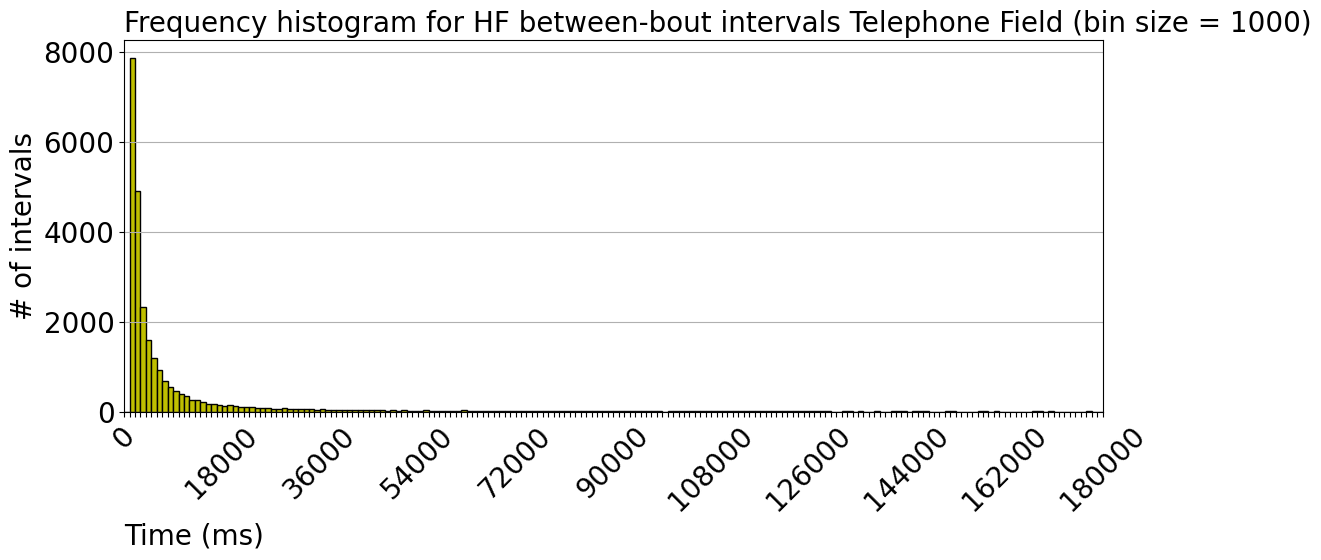

In [13]:
plot_bbi_hist(bout_metrics.copy(), fig_details)
plt.show()

In [14]:
def get_bbi_histogram(bout_metrics, bin_step):
    """
    Uses the IPIs from a location and for a frequency group to compute and return a complete histogram.
    The interval width is set to be 10ms to provide good resolution for the most common IPIs.
    """

    ipis_ms = get_between_bout_intervals_ms(bout_metrics)
    hist_loc = np.histogram(ipis_ms, bins=np.arange(0, ipis_ms.max()+bin_step, bin_step))

    return ipis_ms, hist_loc

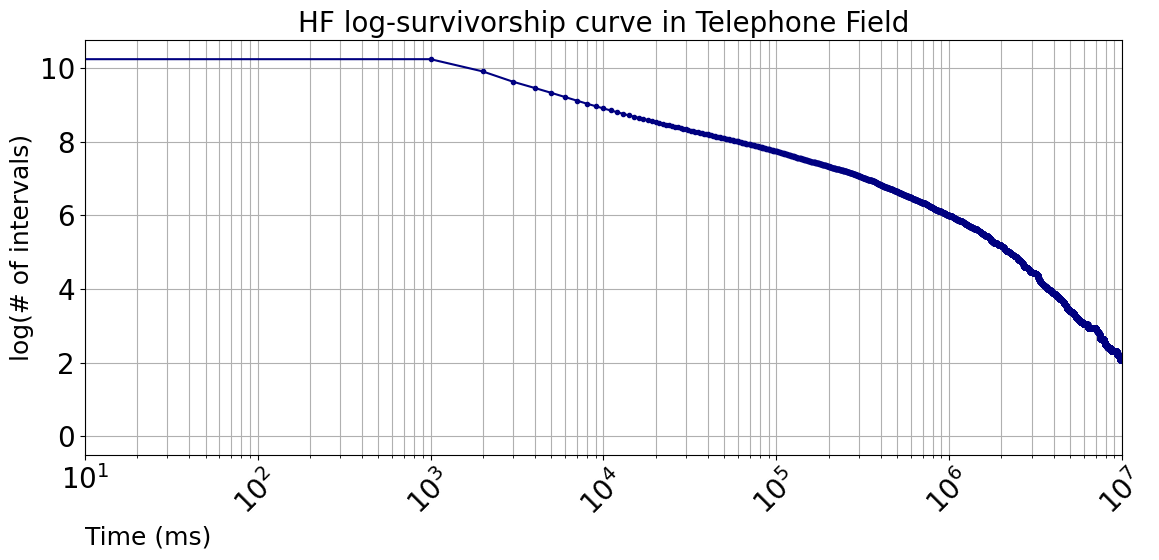

In [15]:
ipis_loc, hist_loc = get_bbi_histogram(bout_metrics.copy(), fig_details['bin_step'])
intervals_ms, survival = get_log_survival(hist_loc)

plot_log_survival(intervals_ms, survival, fig_details)

In [16]:
def regress_around_fast_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.
    """


    fast_inds = intervals_ms <= 10*1e3
    fast_coeff = stats.linregress(intervals_ms[fast_inds], survival[fast_inds])

    fast_process = dict()
    fast_process['metrics'] = fast_coeff
    fast_process['indices'] = fast_inds
    return fast_process

def regress_around_slow_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.

    These interval points to regress around are chosen using values between 30-40% of the max survival.
    We have observed that these points have a strong linear relationship.
    They are also among intervals from 20 to 60min. This range is very likely between-bout.
    """

    # slow_inds = np.logical_and(survival >= (survival.max() * 0.25), survival <= (survival.max() * 0.65)) 
    slow_inds = np.logical_and(intervals_ms >= 300*1e3, survival >= (survival.max() * 0.1))
    slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

    slow_process = dict()
    slow_process['metrics'] = slow_coeff
    slow_process['indices'] = slow_inds
    return slow_process

In [17]:
fast_process = regress_around_fast_intervals(intervals_ms, survival)
fast_process = calculate_exponential_coefficients(fast_process)

In [18]:
slow_process = regress_around_slow_intervals(intervals_ms, survival)
slow_process =  calculate_exponential_coefficients(slow_process)

In [19]:
fg_bci, misassigned_points_fg = get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 785232945 missassigned points
Slater method has 10793565 missassigned points


/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_35204/1334928570.py:49: RuntimeWarning: invalid value encountered in log
  return (np.log((f_intervals*f_lambda*np.exp(-1*f_lambda*t))  + (s_intervals*s_lambda*np.exp(-1*s_lambda*t))))


Sibly method has 178412063 missassigned points
Optim BCI has less misassignments than BCI? False


In [20]:
def plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, optim_x, optim_bci, bci, fig_details):
    """
    Plots the log-survivorship curve of intervals in the time window to visualize the linear regression of the both processs
    along with two derived BCIs (Slater BCI and Sibly BCI) to see where they are in time.
    """

    fast_start = (intervals_ms[fast_process['indices']][0])
    fast_end = (intervals_ms[fast_process['indices']][-1])
    slow_start = (intervals_ms[slow_process['indices']][0])
    slow_end = (intervals_ms[slow_process['indices']][-1])

    plt.figure(figsize=(12, 6))
    plt.rcParams.update({'font.size' : 20})
    plt.title(f"{fig_details['freq_group']}log-survivorship curve in {fig_details['site_name']}", fontsize=20)
    plt.plot(intervals_ms, survival, marker='.', c='cyan', alpha=0.8)

    plt.plot(intervals_ms, clstr.model(intervals_ms, optim_x[0], optim_x[1], optim_x[2], optim_x[3]), marker='.', c='green', alpha=0.1)
    plt.plot(intervals_ms[fast_process['indices']], survival[fast_process['indices']], marker='.', c='navy')
    plt.plot(intervals_ms[slow_process['indices']], survival[slow_process['indices']], marker='.', c='navy')
    plt.axvline(fast_start, linestyle='dashed', color='k')
    plt.axvline(fast_end, linestyle='dashed', color='k')
    plt.axvline(slow_start, linestyle='dashed', color='k')
    plt.axvline(slow_end, linestyle='dashed', color='k')

    x = np.linspace(-100, intervals_ms[-1], int(slow_end))
    plt.plot(x, fast_process['metrics'].intercept + fast_process['metrics'].slope*x, c='red', alpha=0.6, marker=None, label=f"R^2 = {round(fast_process['metrics'].rvalue**2, 4)}")
    plt.plot(x, slow_process['metrics'].intercept + slow_process['metrics'].slope*x, c='blue', alpha=0.6, marker=None, label=f"R^2 = {round(slow_process['metrics'].rvalue**2, 4)}")

    plt.axvline(bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"BCI: {round(bci/1000, 2)}s")
    plt.axvline(optim_bci, linestyle='dashed', linewidth=2, color='yellowgreen', label=f"Optim BCI: {round(optim_bci/1000, 2)}s")
    plt.grid(which='both')
    plt.ylabel('log(# of intervals)', fontsize=18)
    plt.xlabel('Time (ms)', fontsize=18)
    plt.xlim(10e0, 10e6)
    plt.ylim(survival[-1]-0.2, survival[0]+0.2)
    plt.tight_layout()
    plt.legend(loc=3)
    plt.xscale("log")
    plt.show()

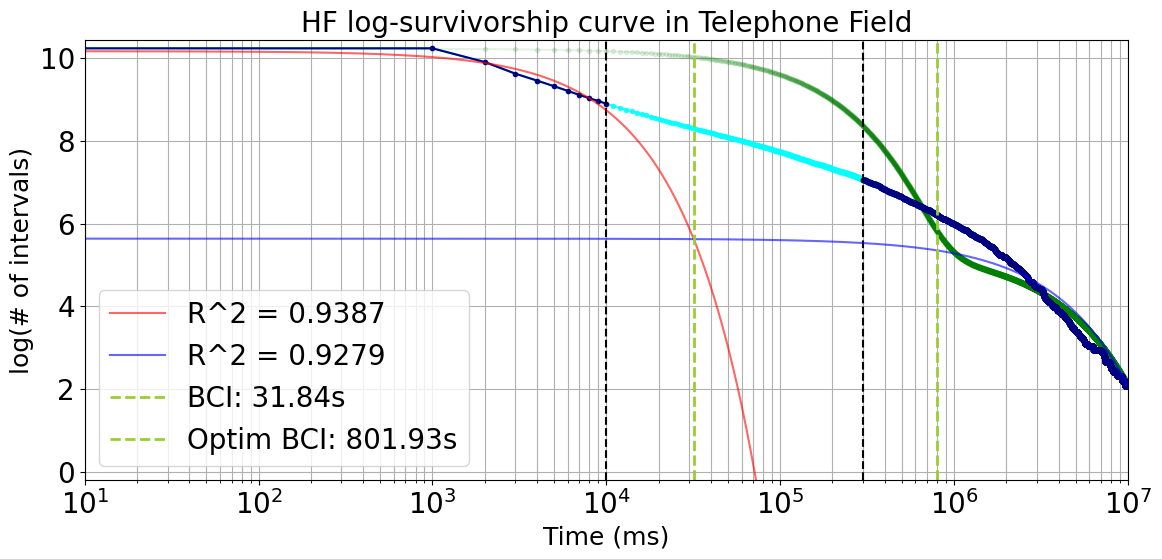

In [21]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [24]:
bout_params[f'HF_bci'] = bci

In [25]:
bout_params

{'site_key': 'Telephone', 'HF_bci': 31840.468642566917}

In [26]:
location_df = bout_metrics.copy()
location_df.insert(0, 'duration_from_last_bout_ms', 0)
location_df.insert(0, 'bout_tag', 0)
location_df.insert(0, 'change_markers', 0)
location_df.insert(0, 'bout_status', '')
result_df = pd.DataFrame()

location_df

,bout_status,change_markers,bout_tag,duration_from_last_bout_ms,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,,0,0,0,2022-07-23 04:28:54.890500,2022-07-23 04:29:04.165100,1734.8905,1744.1651,1734.8905,1744.1651,41796.0,64800.0,HF,2022-07-23 04:00:00,2022-07-23 04:00:00,53,0 days 00:00:09.274600,9.2746
1,,0,0,0,2022-07-23 04:30:11.839500,2022-07-23 04:30:14.868800,11.8395,14.8688,11.8395,14.8688,35781.0,70180.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,21,0 days 00:00:03.029300,3.0293
2,,0,0,0,2022-07-23 04:32:11.407500,2022-07-23 04:32:18.033600,131.4075,138.0336,131.4075,138.0336,39218.0,63030.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,38,0 days 00:00:06.626100,6.6261
3,,0,0,0,2022-07-23 04:32:25.987500,2022-07-23 04:32:29.817600,145.9875,149.8176,145.9875,149.8176,38359.0,59686.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,33,0 days 00:00:03.830100,3.8301
4,,0,0,0,2022-07-23 04:32:31.958500,2022-07-23 04:32:33.575300,151.9585,153.5753,151.9585,153.5753,40078.0,56466.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,12,0 days 00:00:01.616800,1.6168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,,0,0,0,2022-10-17 13:42:56.851500,2022-10-17 13:43:05.489100,776.8515,785.4891,776.8515,785.4891,41796.0,82235.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,31,0 days 00:00:08.637600,8.6376
27986,,0,0,0,2022-10-17 13:45:12.046500,2022-10-17 13:45:13.552900,912.0465,913.5529,912.0465,913.5529,44375.0,59622.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,13,0 days 00:00:01.506400,1.5064
27987,,0,0,0,2022-10-17 13:45:44.199500,2022-10-17 13:45:49.000600,944.1995,949.0006,944.1995,949.0006,41796.0,82357.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,25,0 days 00:00:04.801100,4.8011
27988,,0,0,0,2022-10-17 13:46:06.149500,2022-10-17 13:46:07.291100,966.1495,967.2911,966.1495,967.2911,45234.0,60451.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,6,0 days 00:00:01.141600,1.1416


In [29]:
freq_group_df = location_df.loc[location_df['freq_group']=='HF'].copy()
freq_group_df.reset_index(drop=True, inplace=True)

intervals = (pd.to_datetime(freq_group_df['start_time_of_bout'].values[1:]) - pd.to_datetime(freq_group_df['end_time_of_bout'].values[:-1]))
bbis_f = intervals.to_numpy(dtype='float32')/1e6
bbis_f = np.insert(bbis_f, 0, bout_params[f'HF_bci'])
bbis_f

array([ 31840.469,  67674.4  , 116538.7  , ...,  30646.6  ,  17148.9  ,
        10748.399], dtype=float32)

In [31]:
freq_group_df['duration_from_last_bout_ms'] =  bbis_f
freq_group_df

,bout_status,change_markers,bout_tag,duration_from_last_bout_ms,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,,0,0,31840.468750,2022-07-23 04:28:54.890500,2022-07-23 04:29:04.165100,1734.8905,1744.1651,1734.8905,1744.1651,41796.0,64800.0,HF,2022-07-23 04:00:00,2022-07-23 04:00:00,53,0 days 00:00:09.274600,9.2746
1,,0,0,67674.398438,2022-07-23 04:30:11.839500,2022-07-23 04:30:14.868800,11.8395,14.8688,11.8395,14.8688,35781.0,70180.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,21,0 days 00:00:03.029300,3.0293
2,,0,0,116538.703125,2022-07-23 04:32:11.407500,2022-07-23 04:32:18.033600,131.4075,138.0336,131.4075,138.0336,39218.0,63030.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,38,0 days 00:00:06.626100,6.6261
3,,0,0,7953.899902,2022-07-23 04:32:25.987500,2022-07-23 04:32:29.817600,145.9875,149.8176,145.9875,149.8176,38359.0,59686.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,33,0 days 00:00:03.830100,3.8301
4,,0,0,2140.899902,2022-07-23 04:32:31.958500,2022-07-23 04:32:33.575300,151.9585,153.5753,151.9585,153.5753,40078.0,56466.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,12,0 days 00:00:01.616800,1.6168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,,0,0,8083.100098,2022-10-17 13:42:56.851500,2022-10-17 13:43:05.489100,776.8515,785.4891,776.8515,785.4891,41796.0,82235.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,31,0 days 00:00:08.637600,8.6376
27986,,0,0,126557.398438,2022-10-17 13:45:12.046500,2022-10-17 13:45:13.552900,912.0465,913.5529,912.0465,913.5529,44375.0,59622.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,13,0 days 00:00:01.506400,1.5064
27987,,0,0,30646.599609,2022-10-17 13:45:44.199500,2022-10-17 13:45:49.000600,944.1995,949.0006,944.1995,949.0006,41796.0,82357.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,25,0 days 00:00:04.801100,4.8011
27988,,0,0,17148.900391,2022-10-17 13:46:06.149500,2022-10-17 13:46:07.291100,966.1495,967.2911,966.1495,967.2911,45234.0,60451.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,6,0 days 00:00:01.141600,1.1416


In [32]:
freq_group_df.loc[freq_group_df['duration_from_last_bout_ms'] < bout_params[f'HF_bci'], 'bout_tag'] = 1
freq_group_df.loc[freq_group_df['duration_from_last_bout_ms'] >= bout_params[f'HF_bci'], 'bout_tag'] = 0
wb_indices = freq_group_df.loc[freq_group_df['bout_tag']==1].index
ob_indices = freq_group_df.loc[freq_group_df['bout_tag']==0].index
freq_group_df.loc[wb_indices, 'bout_status'] = 'within superbout'
freq_group_df.loc[ob_indices, 'bout_status'] = 'outside superbout'

bout_tags = freq_group_df['bout_tag']
change_markers = bout_tags.shift(-1) - bout_tags
change_markers[len(change_markers)-1] = 0
freq_group_df['change_markers'] = change_markers
be_indices = freq_group_df.loc[freq_group_df['change_markers']==-1].index
bs_indices = freq_group_df.loc[freq_group_df['change_markers']==1].index
freq_group_df.loc[be_indices, 'bout_status'] = 'superbout end'
freq_group_df.loc[bs_indices, 'bout_status'] = 'superbout start'

num_bout_starts = len(freq_group_df.loc[freq_group_df['bout_status']=='superbout start'])
num_bout_ends = len(freq_group_df.loc[freq_group_df['bout_status']=='superbout end'])
if num_bout_starts != num_bout_ends:
    freq_group_df.at[len(freq_group_df)-1, 'bout_status'] = 'superbout end'

freq_group_df

,bout_status,change_markers,bout_tag,duration_from_last_bout_ms,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
0,outside superbout,0.0,0,31840.468750,2022-07-23 04:28:54.890500,2022-07-23 04:29:04.165100,1734.8905,1744.1651,1734.8905,1744.1651,41796.0,64800.0,HF,2022-07-23 04:00:00,2022-07-23 04:00:00,53,0 days 00:00:09.274600,9.2746
1,outside superbout,0.0,0,67674.398438,2022-07-23 04:30:11.839500,2022-07-23 04:30:14.868800,11.8395,14.8688,11.8395,14.8688,35781.0,70180.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,21,0 days 00:00:03.029300,3.0293
2,superbout start,1.0,0,116538.703125,2022-07-23 04:32:11.407500,2022-07-23 04:32:18.033600,131.4075,138.0336,131.4075,138.0336,39218.0,63030.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,38,0 days 00:00:06.626100,6.6261
3,within superbout,0.0,1,7953.899902,2022-07-23 04:32:25.987500,2022-07-23 04:32:29.817600,145.9875,149.8176,145.9875,149.8176,38359.0,59686.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,33,0 days 00:00:03.830100,3.8301
4,superbout end,-1.0,1,2140.899902,2022-07-23 04:32:31.958500,2022-07-23 04:32:33.575300,151.9585,153.5753,151.9585,153.5753,40078.0,56466.0,HF,2022-07-23 04:30:00,2022-07-23 04:30:00,12,0 days 00:00:01.616800,1.6168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,superbout end,-1.0,1,8083.100098,2022-10-17 13:42:56.851500,2022-10-17 13:43:05.489100,776.8515,785.4891,776.8515,785.4891,41796.0,82235.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,31,0 days 00:00:08.637600,8.6376
27986,superbout start,1.0,0,126557.398438,2022-10-17 13:45:12.046500,2022-10-17 13:45:13.552900,912.0465,913.5529,912.0465,913.5529,44375.0,59622.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,13,0 days 00:00:01.506400,1.5064
27987,within superbout,0.0,1,30646.599609,2022-10-17 13:45:44.199500,2022-10-17 13:45:49.000600,944.1995,949.0006,944.1995,949.0006,41796.0,82357.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,25,0 days 00:00:04.801100,4.8011
27988,within superbout,0.0,1,17148.900391,2022-10-17 13:46:06.149500,2022-10-17 13:46:07.291100,966.1495,967.2911,966.1495,967.2911,45234.0,60451.0,HF,2022-10-17 13:30:00,2022-10-17 13:30:00,6,0 days 00:00:01.141600,1.1416


In [34]:
freq_group_df.loc[(freq_group_df['start_time_of_bout']>=dt.datetime(2022,8,20,3,0,0))&(freq_group_df['end_time_of_bout']<=dt.datetime(2022,8,20,13,0,0))]

,bout_status,change_markers,bout_tag,duration_from_last_bout_ms,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs
3292,superbout start,1.0,0,5.483386e+07,2022-08-20 03:44:24.881500,2022-08-20 03:44:32.409700,864.8815,872.4097,864.8815,872.4097,29765.0,86330.0,HF,2022-08-20 03:30:00,2022-08-20 03:30:00,37,0 days 00:00:07.528200,7.5282
3293,within superbout,0.0,1,1.779800e+03,2022-08-20 03:44:34.189500,2022-08-20 03:44:34.558100,874.1895,874.5581,874.1895,874.5581,38359.0,49331.0,HF,2022-08-20 03:30:00,2022-08-20 03:30:00,2,0 days 00:00:00.368600,0.3686
3294,within superbout,0.0,1,5.750400e+03,2022-08-20 03:44:40.308500,2022-08-20 03:44:41.789600,880.3085,881.7896,880.3085,881.7896,40078.0,50655.0,HF,2022-08-20 03:30:00,2022-08-20 03:30:00,3,0 days 00:00:01.481100,1.4811
3295,within superbout,0.0,1,2.064900e+03,2022-08-20 03:44:43.854500,2022-08-20 03:44:51.493800,883.8545,891.4938,883.8545,891.4938,28046.0,88431.0,HF,2022-08-20 03:30:00,2022-08-20 03:30:00,40,0 days 00:00:07.639300,7.6393
3296,within superbout,0.0,1,4.913700e+03,2022-08-20 03:44:56.407500,2022-08-20 03:45:11.435200,896.4075,911.4352,896.4075,911.4352,28906.0,88244.0,HF,2022-08-20 03:30:00,2022-08-20 03:30:00,62,0 days 00:00:15.027700,15.0277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4869,superbout end,-1.0,1,1.188360e+04,2022-08-20 12:29:41.596500,2022-08-20 12:29:50.366200,1781.5965,1790.3662,1781.5965,1790.3662,42656.0,76140.0,HF,2022-08-20 12:00:00,2022-08-20 12:00:00,61,0 days 00:00:08.769700,8.7697
4870,outside superbout,0.0,0,3.133393e+05,2022-08-20 12:35:03.705500,2022-08-20 12:35:04.460400,303.7055,304.4604,303.7055,304.4604,42656.0,53398.0,HF,2022-08-20 12:30:00,2022-08-20 12:30:00,5,0 days 00:00:00.754900,0.7549
4871,outside superbout,0.0,0,4.681610e+04,2022-08-20 12:35:51.276500,2022-08-20 12:35:53.742100,351.2765,353.7421,351.2765,353.7421,42656.0,56062.0,HF,2022-08-20 12:30:00,2022-08-20 12:30:00,8,0 days 00:00:02.465600,2.4656
4872,superbout start,1.0,0,4.455414e+05,2022-08-20 12:43:19.283500,2022-08-20 12:43:19.706700,799.2835,799.7067,799.2835,799.7067,43515.0,59438.0,HF,2022-08-20 12:30:00,2022-08-20 12:30:00,3,0 days 00:00:00.423200,0.4232


In [35]:
location_df = freq_group_df.copy()
location_df.reset_index(drop=True, inplace=True)
group_of_tagged_dets = location_df['freq_group'].unique().item()

end_times_of_bouts = pd.to_datetime(location_df.loc[location_df['bout_status']=='superbout end', 'end_time_of_bout'])
start_times_of_bouts = pd.to_datetime(location_df.loc[location_df['bout_status']=='superbout start', 'start_time_of_bout'])
ref_end_times = location_df.loc[location_df['bout_status']=='superbout end', 'end_time_wrt_ref'].astype('float')
ref_start_times = location_df.loc[location_df['bout_status']=='superbout start', 'start_time_wrt_ref'].astype('float')
end_times = location_df.loc[location_df['bout_status']=='superbout end', 'end_time'].astype('float')
start_times = location_df.loc[location_df['bout_status']=='superbout start', 'start_time'].astype('float')
bout_starts = start_times_of_bouts.index
bout_ends = end_times_of_bouts.index


end_times_of_bouts

4       2022-07-23 04:32:33.575300
6       2022-07-23 04:34:34.374800
9       2022-07-23 04:36:56.139400
17      2022-07-23 04:40:07.843800
22      2022-07-23 04:44:39.343800
                   ...            
27956   2022-10-17 13:34:55.593800
27963   2022-10-17 13:37:02.413400
27971   2022-10-17 13:39:06.118900
27985   2022-10-17 13:43:05.489100
27989   2022-10-17 13:46:18.723900
Name: end_time_of_bout, Length: 2110, dtype: datetime64[ns]

In [36]:
start_times_of_bouts

2       2022-07-23 04:32:11.407500000
5       2022-07-23 04:34:25.958500000
8       2022-07-23 04:36:44.513499999
10      2022-07-23 04:38:30.178500000
19      2022-07-23 04:43:49.262500000
                     ...             
27950   2022-10-17 13:34:10.881500000
27957   2022-10-17 13:36:01.956500000
27964   2022-10-17 13:37:50.131500000
27973   2022-10-17 13:40:27.776500000
27986   2022-10-17 13:45:12.046500000
Name: start_time_of_bout, Length: 2110, dtype: datetime64[ns]

In [37]:
low_freqs = []
high_freqs = []
ref_time_cycle_start = []
ref_time_cycle_end = []
num_calls_per_bout = []
for i, bout_start in enumerate(bout_starts):
    bat_bout = location_df.iloc[bout_start:bout_ends[i]+1]
    pass_low_freq = np.min(bat_bout['low_freq'])
    pass_high_freq = np.max(bat_bout['high_freq'])
    num_calls = len(bat_bout)
    low_freqs += [pass_low_freq]
    high_freqs += [pass_high_freq]
    num_calls_per_bout += [num_calls]

superbout_metrics = pd.DataFrame()
superbout_metrics['start_time_of_bout'] = start_times_of_bouts.values
superbout_metrics['end_time_of_bout'] = end_times_of_bouts.values
superbout_metrics['start_time_wrt_ref'] = ref_start_times.values
superbout_metrics['end_time_wrt_ref'] = ref_end_times.values
superbout_metrics['start_time'] = start_times.values
superbout_metrics['end_time'] = end_times.values
superbout_metrics['low_freq'] = low_freqs
superbout_metrics['high_freq'] = high_freqs
superbout_metrics['freq_group'] = group_of_tagged_dets
superbout_metrics['number_of_dets'] = num_calls_per_bout
superbout_metrics['bout_duration'] = end_times_of_bouts.values - start_times_of_bouts.values
superbout_metrics['bout_duration_in_secs'] = superbout_metrics['bout_duration'].apply(lambda x : x.total_seconds())

superbout_metrics

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,number_of_dets,bout_duration,bout_duration_in_secs
0,2022-07-23 04:32:11.407500000,2022-07-23 04:32:33.575300,131.4075,153.5753,131.4075,153.5753,38359.0,63030.0,HF,3,0 days 00:00:22.167800,22.1678
1,2022-07-23 04:34:25.958500000,2022-07-23 04:34:34.374800,265.9585,274.3748,265.9585,274.3748,35781.0,61253.0,HF,2,0 days 00:00:08.416300,8.4163
2,2022-07-23 04:36:44.513499999,2022-07-23 04:36:56.139400,404.5135,416.1394,404.5135,416.1394,36640.0,64815.0,HF,2,0 days 00:00:11.625900001,11.6259
3,2022-07-23 04:38:30.178500000,2022-07-23 04:40:07.843800,510.1785,607.8438,510.1785,607.8438,34062.0,70136.0,HF,8,0 days 00:01:37.665300,97.6653
4,2022-07-23 04:43:49.262500000,2022-07-23 04:44:39.343800,829.2625,879.3438,829.2625,879.3438,38359.0,56715.0,HF,4,0 days 00:00:50.081300,50.0813
...,...,...,...,...,...,...,...,...,...,...,...,...
2105,2022-10-17 13:34:10.881500000,2022-10-17 13:34:55.593800,250.8815,295.5938,250.8815,295.5938,40078.0,79539.0,HF,7,0 days 00:00:44.712300,44.7123
2106,2022-10-17 13:36:01.956500000,2022-10-17 13:37:02.413400,361.9565,422.4134,361.9565,422.4134,40937.0,72673.0,HF,7,0 days 00:01:00.456900,60.4569
2107,2022-10-17 13:37:50.131500000,2022-10-17 13:39:06.118900,470.1315,546.1189,470.1315,546.1189,40937.0,83222.0,HF,8,0 days 00:01:15.987400,75.9874
2108,2022-10-17 13:40:27.776500000,2022-10-17 13:43:05.489100,627.7765,785.4891,627.7765,785.4891,40078.0,82235.0,HF,13,0 days 00:02:37.712600,157.7126


In [38]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
single_night_files = files_from_loc[:21]

In [48]:
example_bouts = superbout_metrics.loc[(superbout_metrics['start_time_of_bout']>=dt.datetime(2022,8,20,3,0,0))&(superbout_metrics['start_time_of_bout']<=dt.datetime(2022,8,20,13,0,0))].copy()
example_bouts

,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,number_of_dets,bout_duration,bout_duration_in_secs
238,2022-08-20 03:44:24.881500,2022-08-20 03:49:24.267600000,864.8815,1164.2676,864.8815,1164.2676,28046.0,88431.0,HF,27,0 days 00:04:59.386100,299.386100
239,2022-08-20 03:50:06.373500,2022-08-20 03:54:07.074400000,1206.3735,1447.0744,1206.3735,1447.0744,29765.0,86730.0,HF,26,0 days 00:04:00.700900,240.700900
240,2022-08-20 03:55:28.923500,2022-08-20 03:55:49.755200000,1528.9235,1549.7552,1528.9235,1549.7552,34062.0,65337.0,HF,4,0 days 00:00:20.831700,20.831700
241,2022-08-20 03:56:27.800500,2022-08-20 03:59:36.375200000,1587.8005,1776.3752,1587.8005,1776.3752,29765.0,82526.0,HF,16,0 days 00:03:08.574700,188.574700
242,2022-08-20 04:00:21.061500,2022-08-20 04:00:40.129399999,21.0615,40.1294,21.0615,40.1294,38359.0,53517.0,HF,2,0 days 00:00:19.067899999,19.067899
...,...,...,...,...,...,...,...,...,...,...,...,...
310,2022-08-20 12:07:12.106500,2022-08-20 12:07:53.795400000,432.1065,473.7954,432.1065,473.7954,36640.0,84187.0,HF,5,0 days 00:00:41.688900,41.688900
311,2022-08-20 12:08:35.600500,2022-08-20 12:09:35.902900000,515.6005,575.9029,515.6005,575.9029,34062.0,92674.0,HF,8,0 days 00:01:00.302400,60.302400
312,2022-08-20 12:26:18.056500,2022-08-20 12:26:21.920000000,1578.0565,1581.9200,1578.0565,1581.9200,40937.0,56429.0,HF,2,0 days 00:00:03.863500,3.863500
313,2022-08-20 12:29:29.083500,2022-08-20 12:29:50.366200000,1769.0835,1790.3662,1769.0835,1790.3662,41796.0,76140.0,HF,2,0 days 00:00:21.282700,21.282700


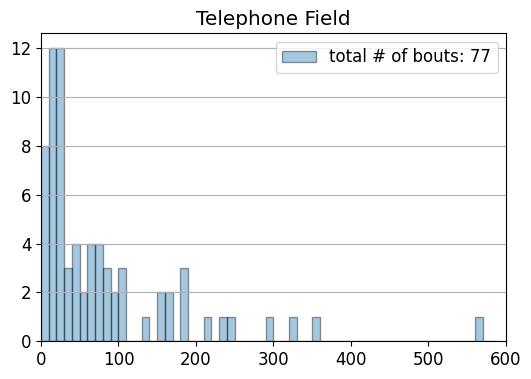

In [45]:
bout_metrics_HF = example_bouts[example_bouts['freq_group']=='HF'].copy()
hf_bci = bout_params['HF_bci']

bout_durations_raw_HF = bout_metrics_HF["bout_duration_in_secs"].sort_values(ascending=False)
hf_labels = f'total # of bouts: {len(bout_durations_raw_HF)}'

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size':12})
plt.title(f'{SITE_NAMES[site_key]}')
x_lims = [0, 600]
x_step = 10
plt.hist(bout_durations_raw_HF, bins=np.arange(x_lims[0],x_lims[-1], x_step), edgecolor='k', label=hf_labels, alpha=0.4)
plt.grid(axis='y')
plt.legend(loc=1)
plt.xlim(x_lims[0],x_lims[-1])
plt.show()

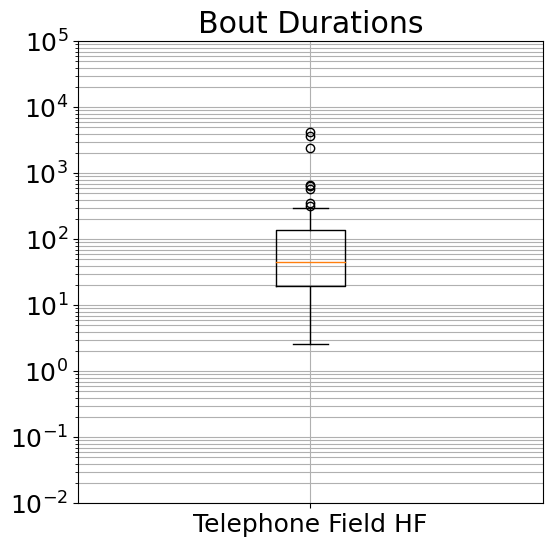

In [47]:
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'Bout Durations')
plt.boxplot([bout_durations_raw_HF])
plt.xticks([1], ['Telephone Field HF'])
plt.yscale('log')
plt.ylim(0.01, 1e5)
# plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

In [35]:
def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    # plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        btp_per_cycle = actvt.get_btp_per_time_on(bout_duration_per_cycle, data_params['time_on_in_secs'])
        plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()

def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=((row['low_freq']-6000)/(fs/2)), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='green', weight='bold', fontsize=14)
        # plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=((row['high_freq']+2000)/(fs/2)), 
        #                     s=f"{round(row['number_of_dets'], 2)} dets", color='red', weight='bold', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)


def plot_recording_periods_with_btp(ax, audio_features, data_params, btp_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.10, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold', alpha=0.6)
                window_count+=1
            ax.add_patch(rect)

def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_dets, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """
    
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    # plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    ax = plt.gca()
    plot_bout_info(ax, audio_features, plot_bouts)
    # plot_recording_periods(ax, audio_features, data_params)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

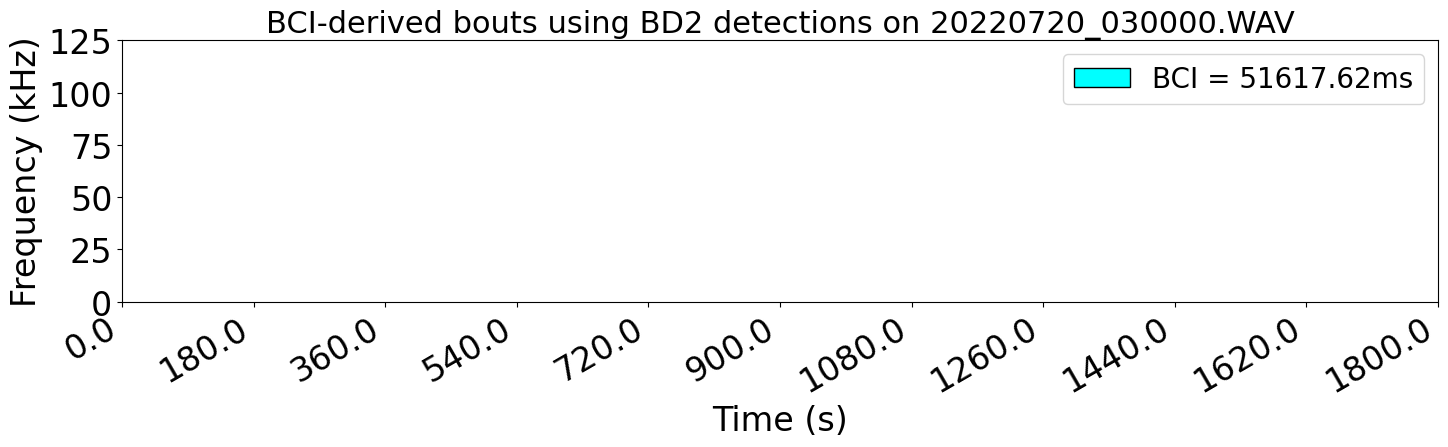

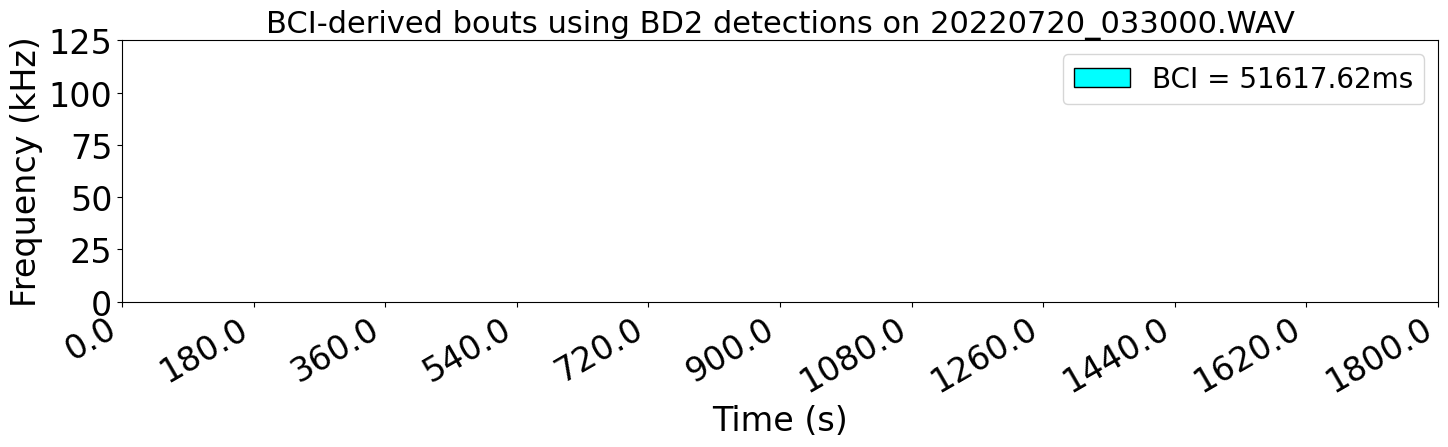

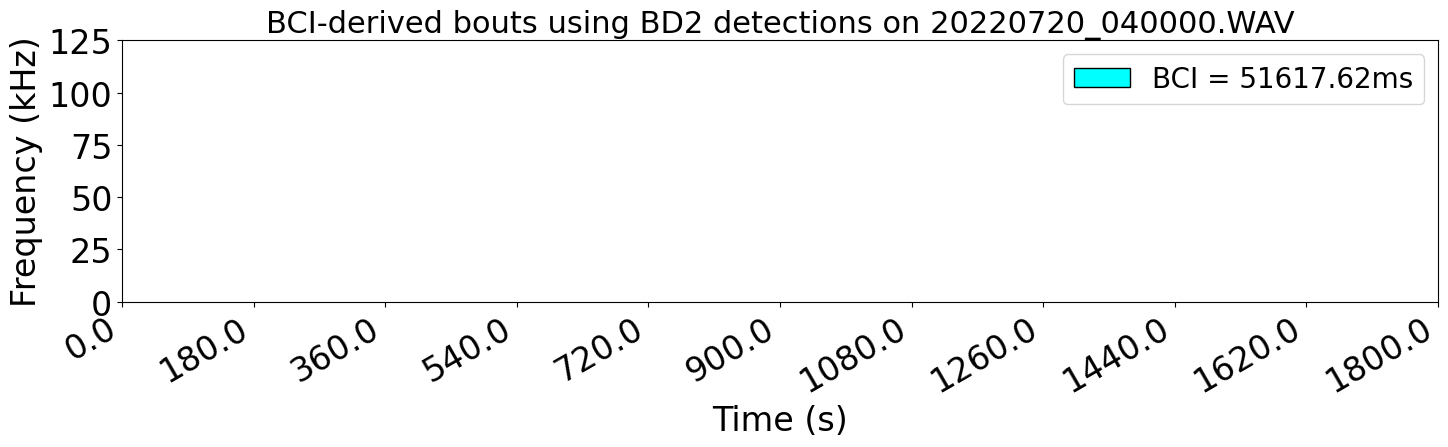

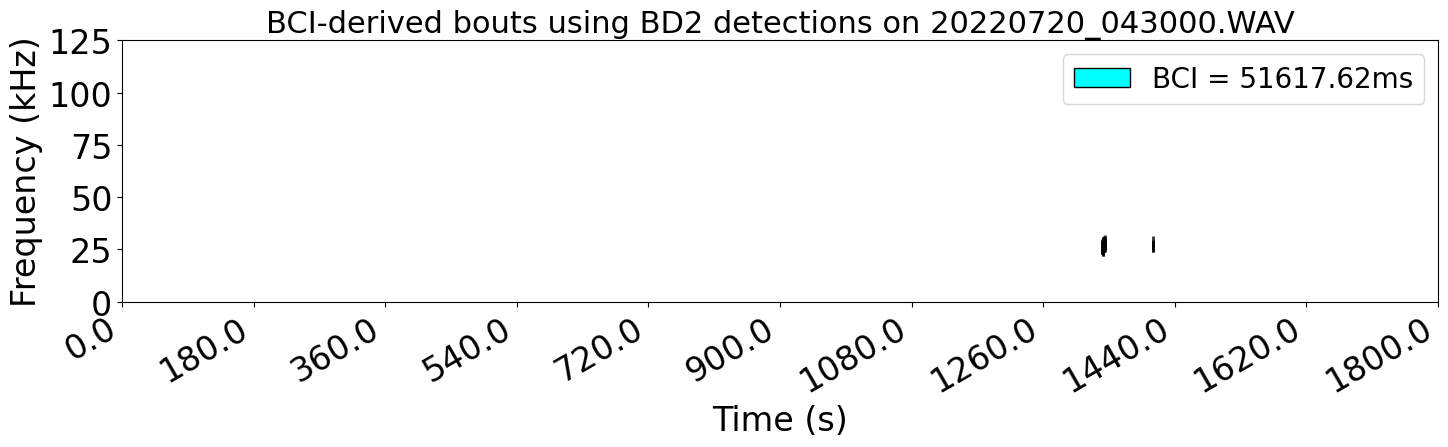

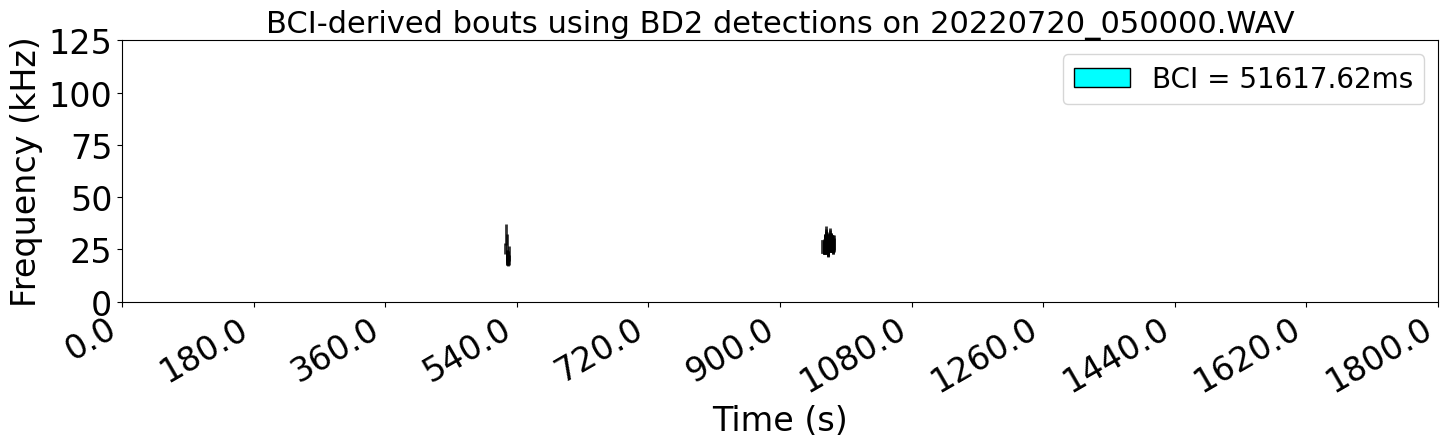

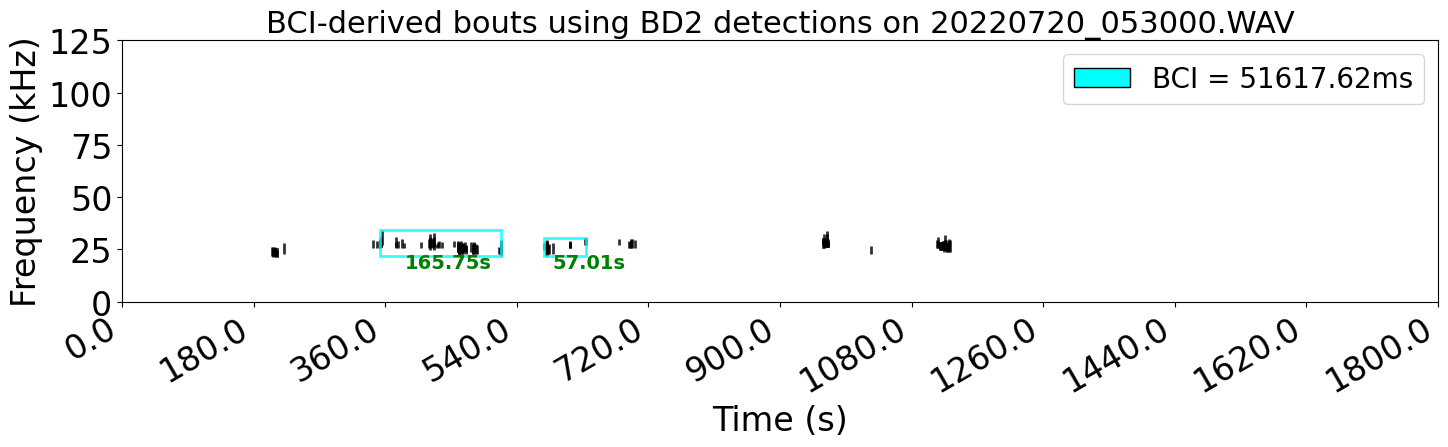

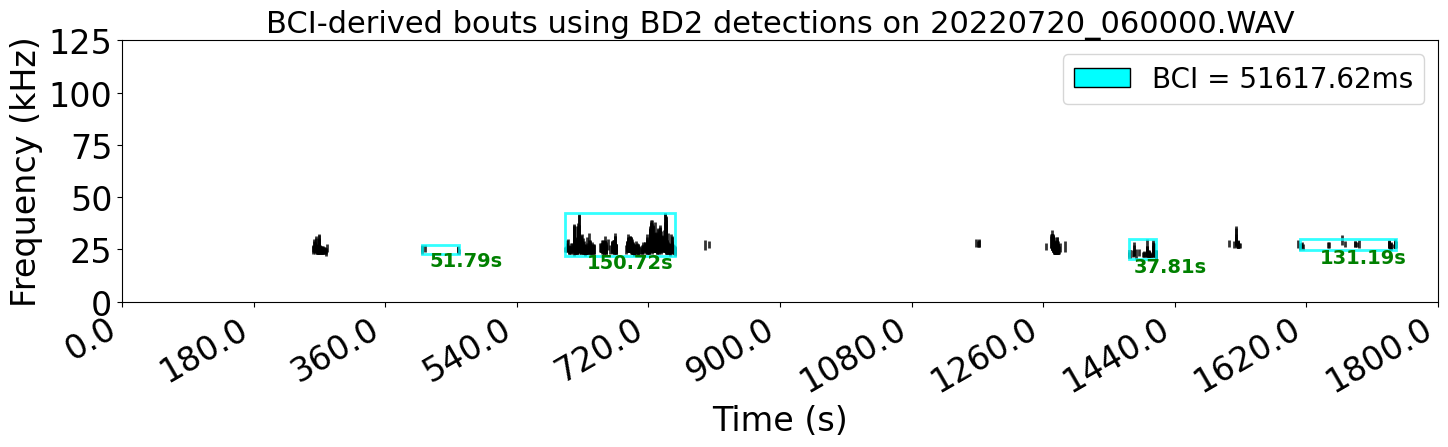

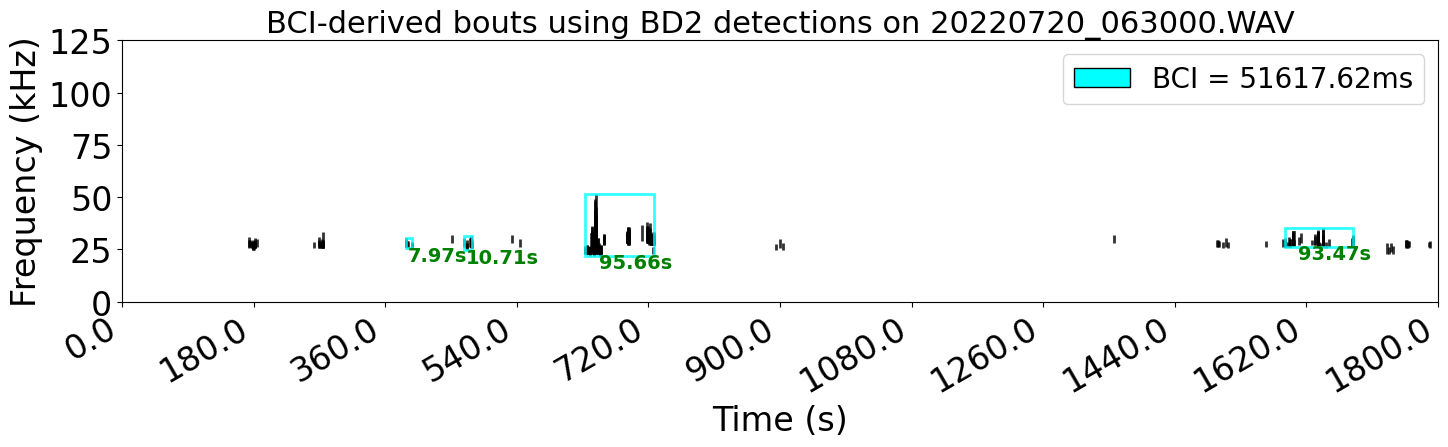

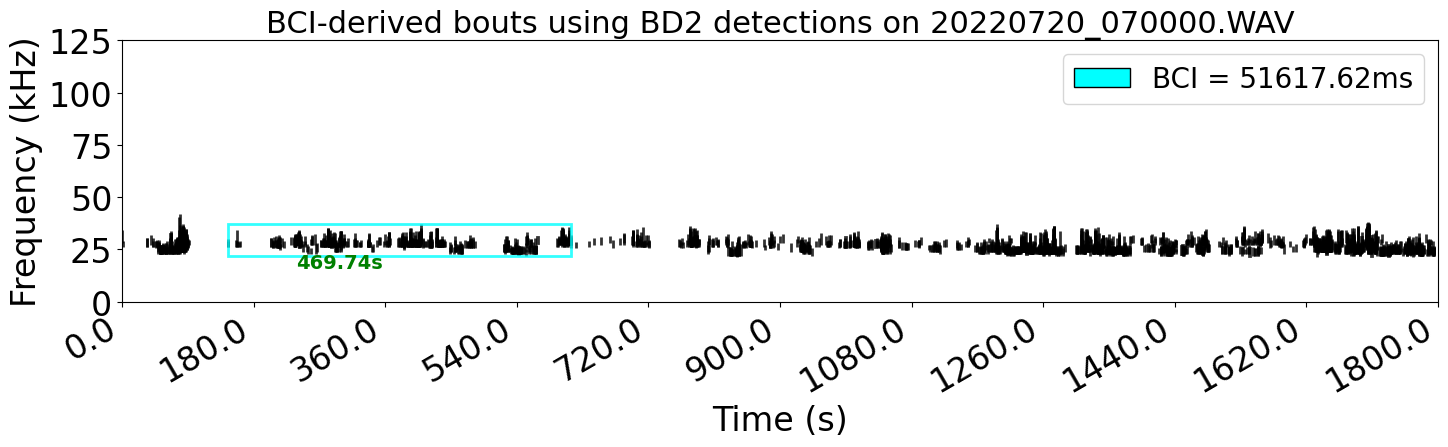

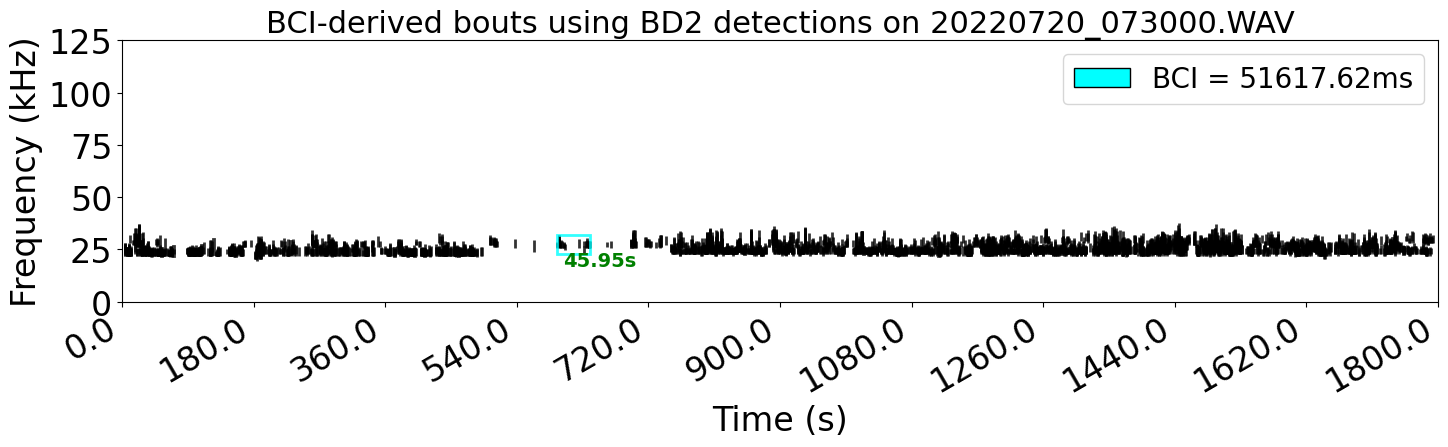

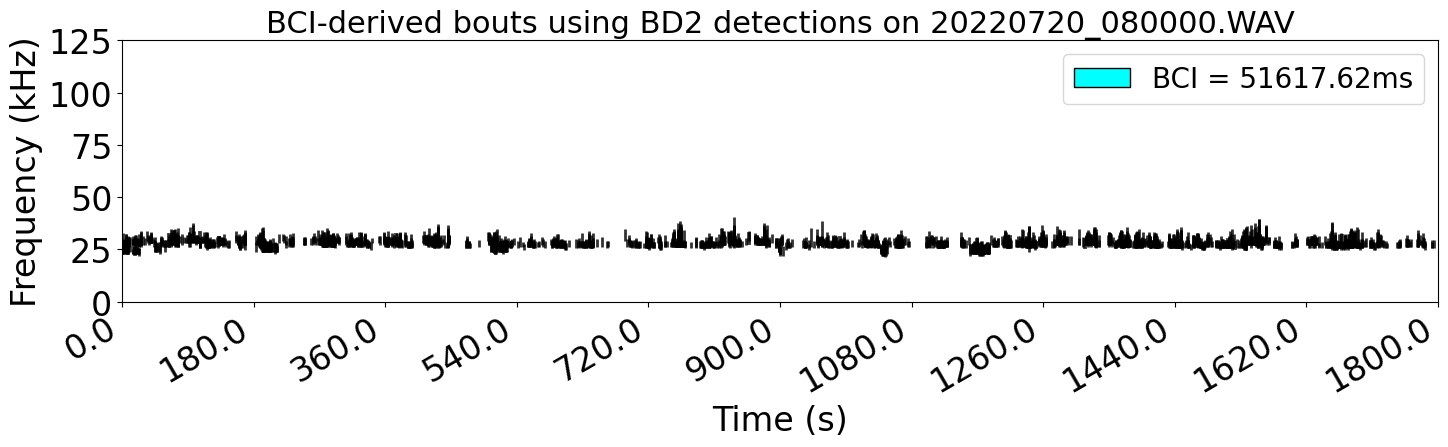

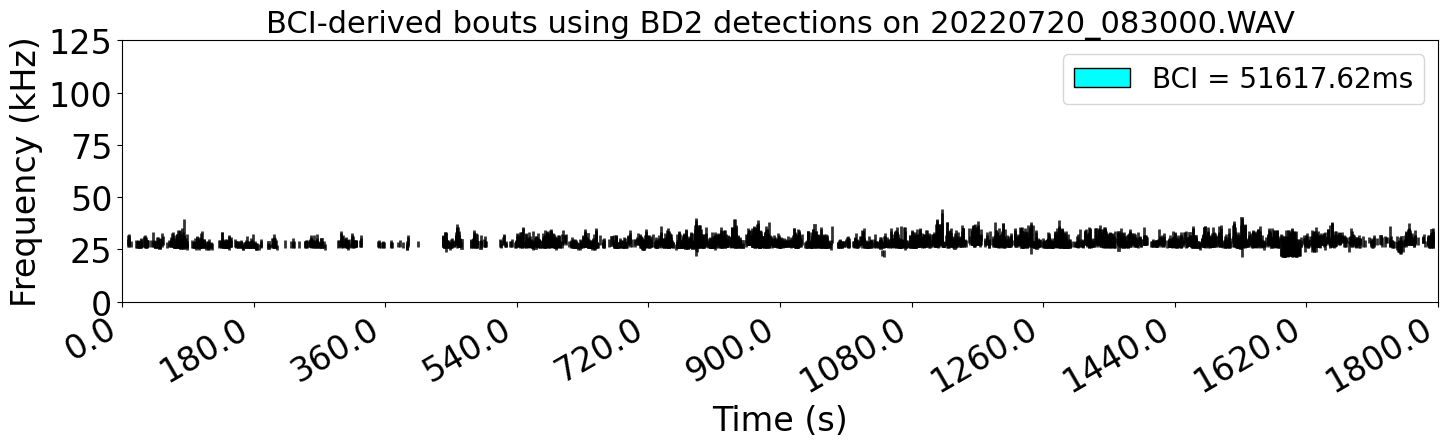

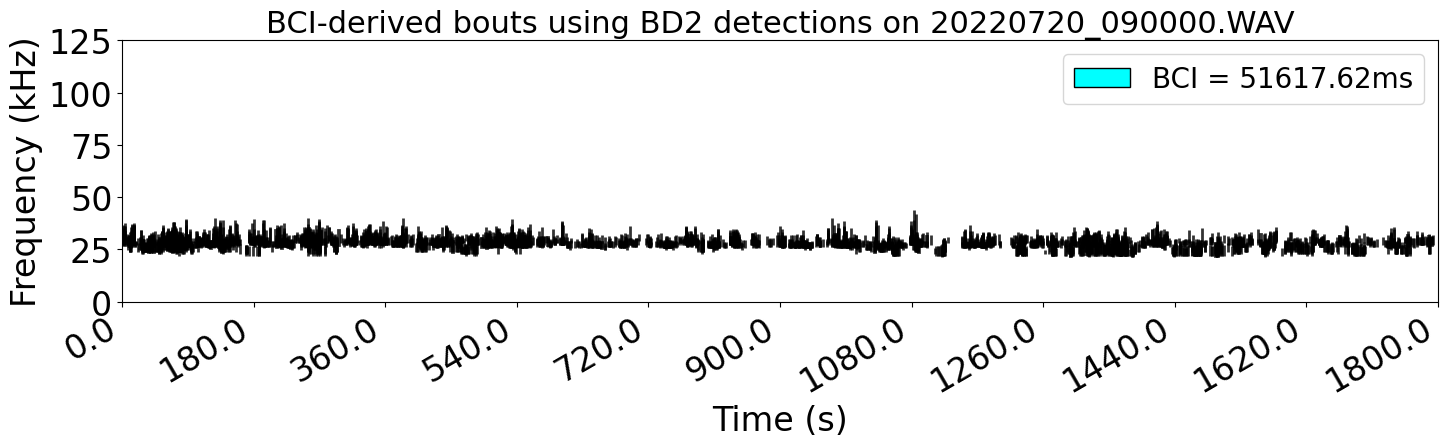

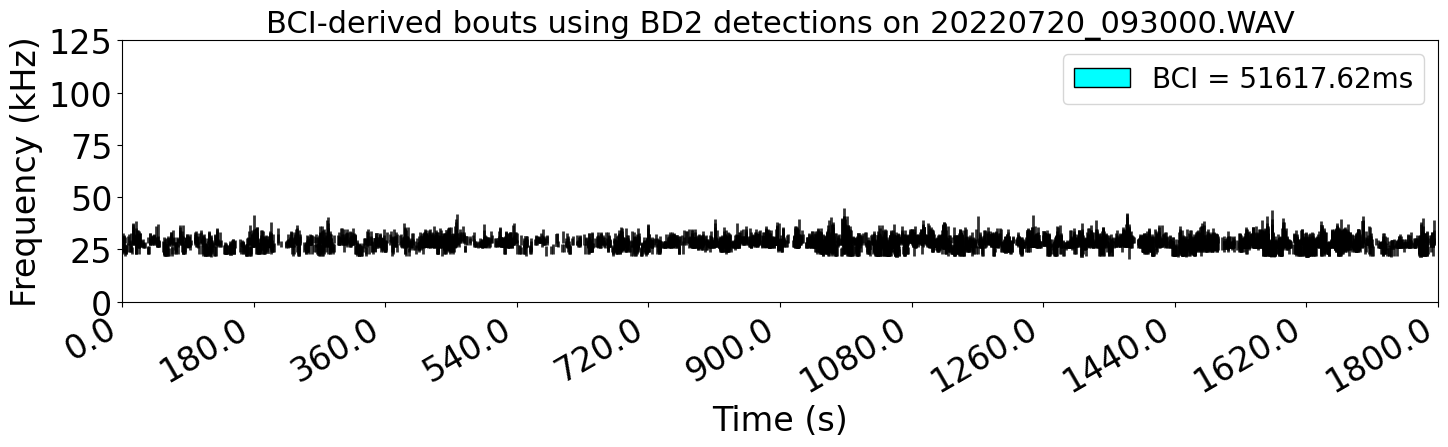

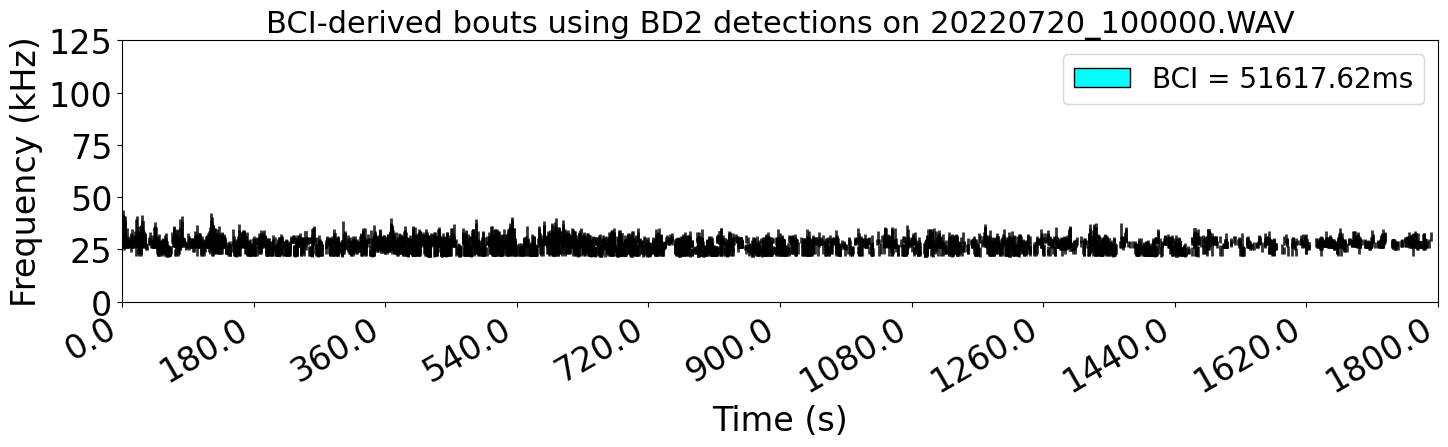

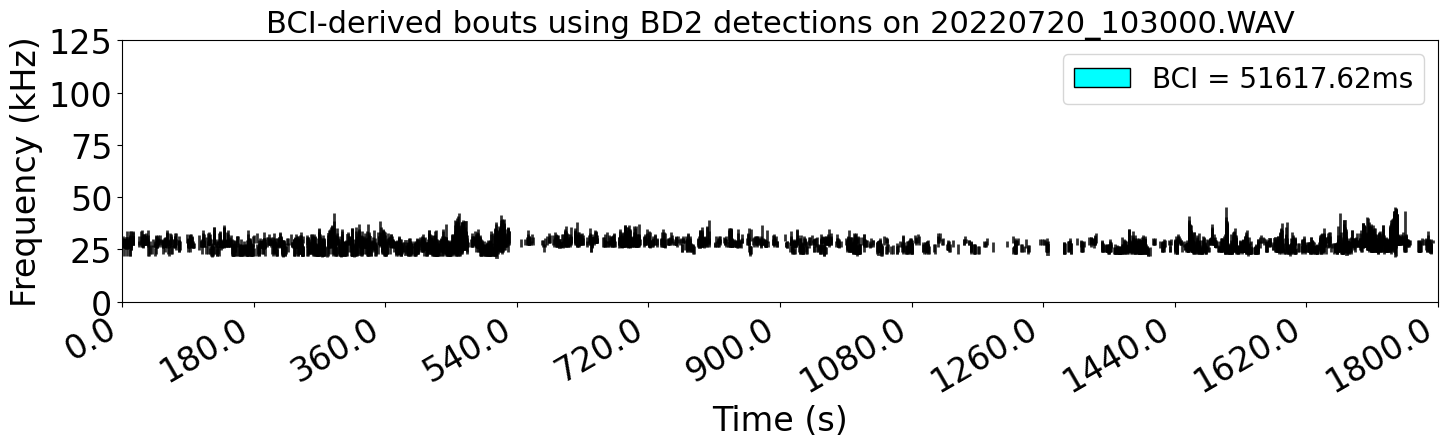

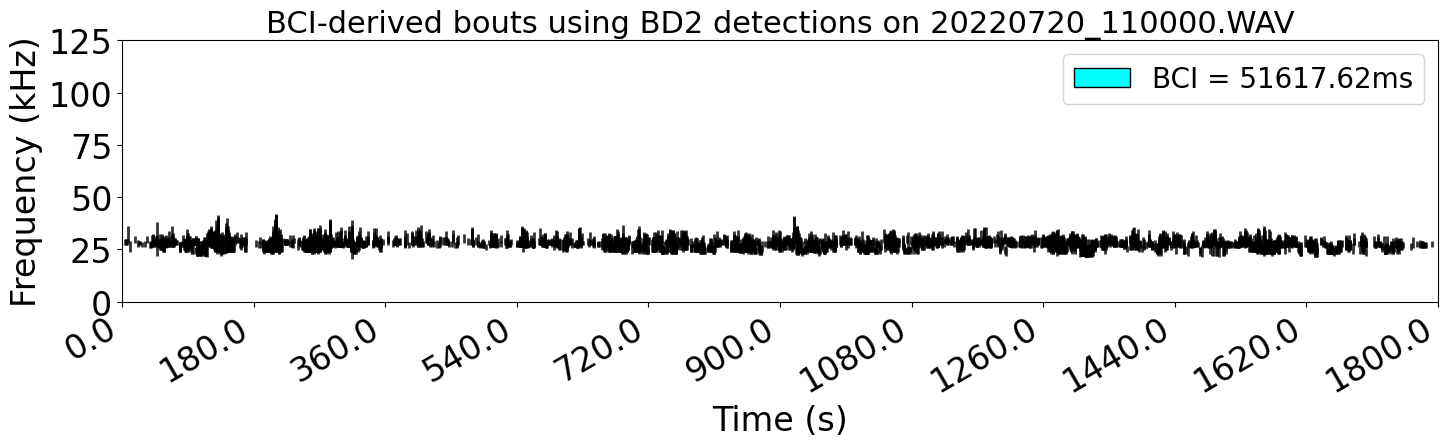

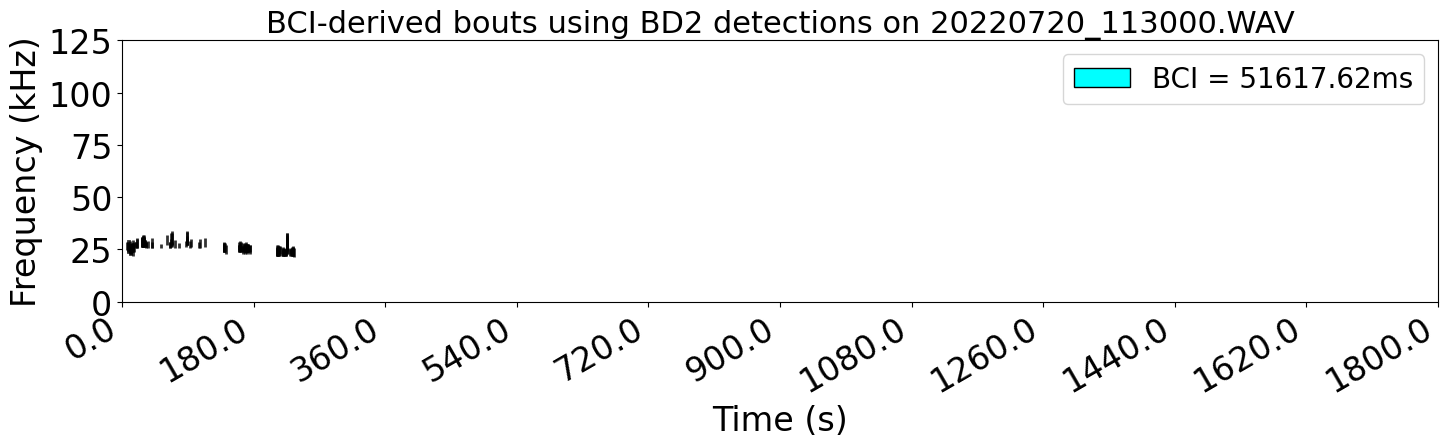

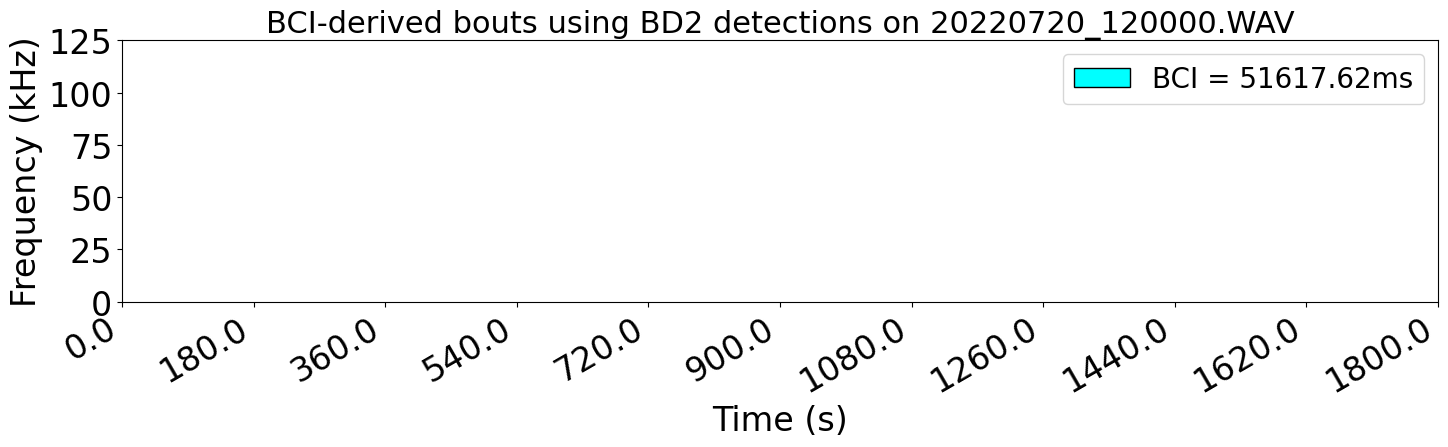

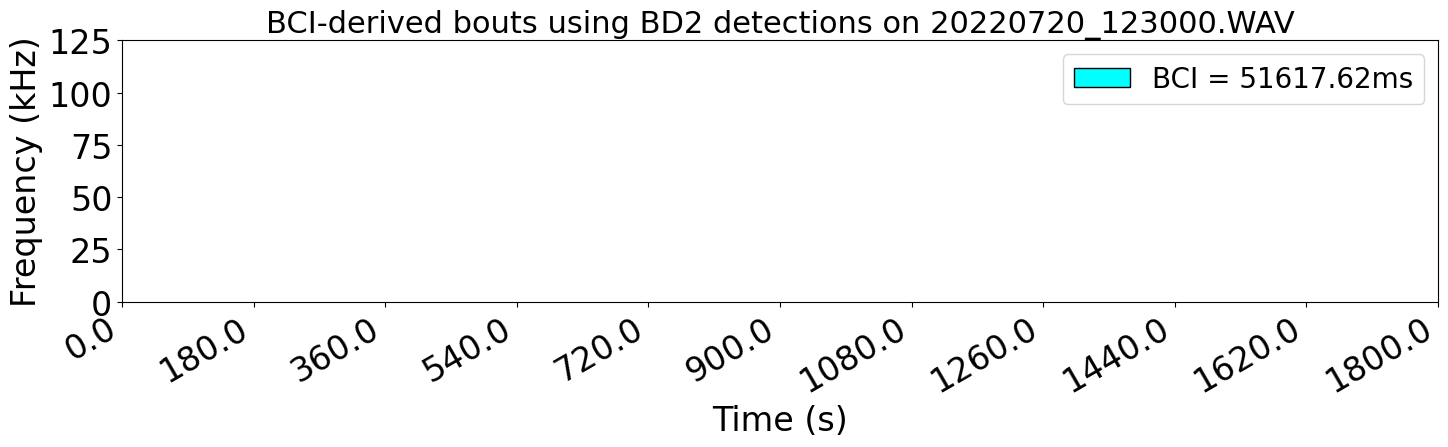

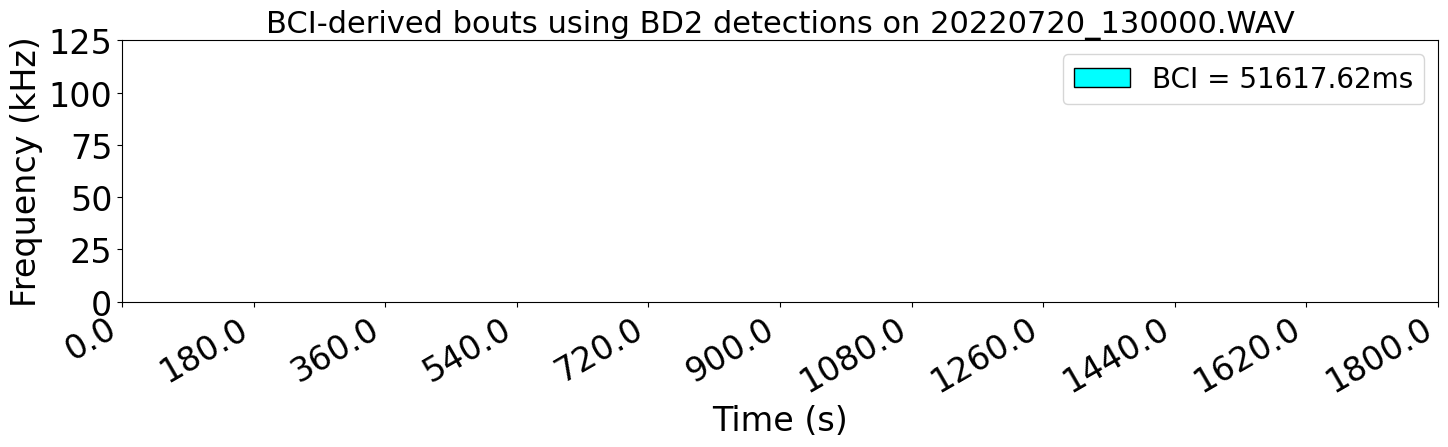

In [36]:
for file in single_night_files:
    file_path = Path(file)
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 0
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
    file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

    plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
    plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
    if not(plot_dets.empty):
        plot_bouts = superbout_metrics.loc[(superbout_metrics['start_time_of_bout']>=file_dt_start)&(superbout_metrics['end_time_of_bout']<=file_dt_end)]
        plot_bouts = plot_bouts.loc[(plot_bouts['start_time'] >= start)&(plot_bouts['end_time'] <= (start+duration))]
    else:
        plot_bouts = pd.DataFrame()
    # bt_plt.plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
    plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_dets, plot_bouts)